In [125]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw

In [126]:
def BaseShape(l, w):
    wp1 = WorkPlane().RectangleC(l,w).Face()
    wp2 = WorkPlane().RectangleC(w,l).Face()
    cross = wp1 + wp2
    return cross


l = 0.3
w = 1
base = BaseShape(l, w)

In [127]:
offset = 3
figure = base
for i in range(3):
    for j in range(3):
        if (i+j) % 2 == 0:
            figure += BaseShape(i,j).Move((i*offset, j*offset, 0))
        else:
            if i+j == 1:
                figure += WorkPlane().Circle(1).Face().Move((i*offset, j*offset, 0))
            else:
                figure += base.Mirror(Axis((0, 0, 0), (1, 0, 0))
                      ).Move((i*offset, j*offset, 0))


geo = WorkPlane().Rectangle(5,5).Face() -  figure.Move((-2,-2,0))
Draw(geo)

geo.edges.Min(Y).name ='bottom'
geo.edges.Max(Y).name ='top'
geo.edges.Min(X).name ='left'
geo.edges.Max(X).name ='right'

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [128]:
Draw(geo, filename='./Test')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

In [129]:
plate = OCCGeometry(geo, dim=2)
mesh = Mesh(plate.GenerateMesh(maxh=0.5)).Curve(3)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [130]:
# H1-conforming finite element space
fes = H1(mesh, order=1, dirichlet="bottom", autoupdate=True)
# define trial- and test-functions
u = fes.TrialFunction()
v = fes.TestFunction()

In [131]:
# the bilinear-form 
a = BilinearForm(grad(u)*grad(v)*dx)

funcf = 50*x*y
# funcf = 50*sin(y)
f = LinearForm(funcf*v*dx)

a.Assemble()
f.Assemble()
Draw(funcf,mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [132]:
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
Draw(gfu);
# Draw(grad(gfu),mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [133]:
 Draw(grad(gfu),mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [134]:
import numpy as np
import torch

vertex_coordinates = []

for v in mesh.vertices:
    vertex_coordinates.append(v.point)

vertex_array = torch.tensor(np.array(vertex_coordinates))

In [147]:
vertex_array.shape
x = vertex_array[:, 0]
y = vertex_array[:, 1]
x.shape

torch.Size([121])

In [148]:
sol =  torch.tensor([x for x in gfu.vec])

In [149]:
sol.shape

torch.Size([121])

In [150]:
x.max(), y.max(), x.min(), y.min()

(tensor(5., dtype=torch.float64),
 tensor(5.0000, dtype=torch.float64),
 tensor(-8.2641e-16, dtype=torch.float64),
 tensor(0., dtype=torch.float64))

In [151]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [164]:
batch_size = 32

In [165]:
class FeedForward(nn.Module):

    def __init__(self):
        super(FeedForward, self).__init__()

        self.optimizer = None
        self.train_loss_history = []

        # weights for the total loss function
        self.w1 = 0.001  #loss_data
        self.w2 = 1      #loss_interior
        self.w3 = 5      #loss_bc

        self.hidden_size = 50

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # initialize weights
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)


    def forward(self, x, y):  

        xy = torch.stack((x, y), dim=1)

        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u

    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of u = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)

    def PDE_residual(self, x, y, use_meshgrid = False):
        if use_meshgrid:

            X,Y = torch.meshgrid(x,y)
            xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        x.requires_grad=True
        y.requires_grad=True

        u = self.forward(x, y)

        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 - 50*x*y  
        return residual



    def loss_data(self):
        input, output = next(iter(train_loader))
        x_sol, y = input.T
        u = output

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        u = torch.tensor(u, dtype=torch.float32).to(device)

        u_pred = self.forward(x, y)
        loss_data = torch.mean(torch.square(u - u_pred))
        return loss_data

    def loss_interior(self): #uniform sampling of x and y between [0,1] to pass to PDE_residual
        #x_samples = torch.FloatTensor(self.num_samples, 1).uniform_(0, 1).flatten().to(device).requires_grad_(True)
        #y_samples = torch.FloatTensor(self.num_samples, 1).uniform_(0, 1).flatten().to(device).requires_grad_(True)
        res = self.PDE_residual(x, y)
        loss_residual = torch.mean(torch.square(res)) #like rms error
        return loss_residual

    def loss_boundary_condition(self):

        self.x_bottom = torch.linspace(0, 5, 100).reshape(-1)
        self.y_bottom = torch.zeros(1, 100).reshape(-1)

        bc_pred_bottom = self.forward(self.x_bottom.to(device), self.y_bottom.to(device))
        loss_bc_bottom = torch.mean(torch.square(bc_pred_bottom))

        loss_bc = loss_bc_bottom 
        return loss_bc

    def compute_losses(self):  
        loss_interior = self.loss_interior()
        #loss_data = self.loss_data()
        loss_data = torch.tensor([0])
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_data, loss_bc


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data, loss_bc = self.compute_losses() 
        total_loss = self.w1 * loss_data + self.w2 * loss_interior + self.w3 * loss_bc   
        total_loss.backward(retain_graph=True)
        return total_loss

    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        total_loss, loss_bc, loss_interior, loss_data = np.split(loss_hist, 4, axis=1)
        return total_loss, loss_bc, loss_interior, loss_data
 
          

    def plot_losses(self):
            total_loss, loss_interior, loss_data, loss_bc = self.get_training_history()

            plt.figure(figsize=(12, 8))

            plt.subplot(2, 2, 1)
            plt.plot(total_loss, marker=MarkerStyle('o', fillstyle='none'), color='black', label='Total Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(loss_bc, marker=MarkerStyle('o', fillstyle='none'), color='red', alpha = 0.8, label='Boundary Condition Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(loss_interior, marker=MarkerStyle('o', fillstyle='none'), color='blue', alpha = 0.2, label='Interior Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(loss_data, marker=MarkerStyle('o', fillstyle='none'), color='green', alpha = 0.1, label='Data Loss')
            plt.yscale('log')
            plt.legend()

            plt.tight_layout()
            plt.show()

In [166]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FeedForward().to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

cpu
FeedForward(
  (b1): Linear(in_features=2, out_features=50, bias=True)
  (b2): Linear(in_features=50, out_features=50, bias=True)
  (b3): Linear(in_features=50, out_features=1, bias=True)
)
Params: 2751


In [167]:
def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            
            # track progress and accumulate loss data for plotting
            if epoch % 1000 == 0:
                loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_bc 

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy(),
                                                loss_bc.cpu().detach().numpy()
                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

In [169]:
train(model, 10_000, lr=1e-4)

Epoch (Adam): 0, Total Loss: 50601.23046875
Epoch (Adam): 1000, Total Loss: 46235.171875
Epoch (Adam): 2000, Total Loss: 42094.1953125
Epoch (Adam): 3000, Total Loss: 39933.56640625
Epoch (Adam): 4000, Total Loss: 38987.80078125
Epoch (Adam): 5000, Total Loss: 38484.77734375
Epoch (Adam): 6000, Total Loss: 36426.3046875
Epoch (Adam): 7000, Total Loss: 33532.08203125
Epoch (Adam): 8000, Total Loss: 31848.462890625
Epoch (Adam): 9000, Total Loss: 30767.125


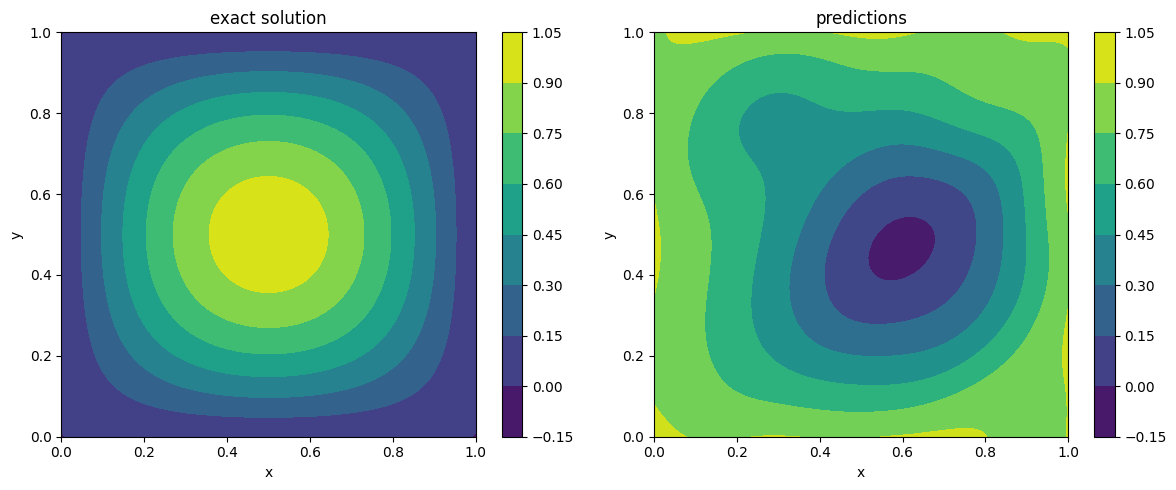

In [114]:
x_data = torch.linspace(0,1,100)
y_data = torch.linspace(0,1,100)
X_data, Y_data = torch.meshgrid(x_data, y_data)
sol = torch.sin(torch.pi * X_data) * torch.sin(torch.pi * Y_data)

u_pred = model.forward(X_data.flatten().to(device), Y_data.flatten().to(device))
u_pred = u_pred.detach().cpu().numpy()
u_pred = u_pred.reshape(len(x_data), len(y_data))

# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the solution and noisy data
contour_sol = axs[0].contourf(X_data, Y_data, sol, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("exact solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X_data, Y_data, u_pred, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("predictions")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()

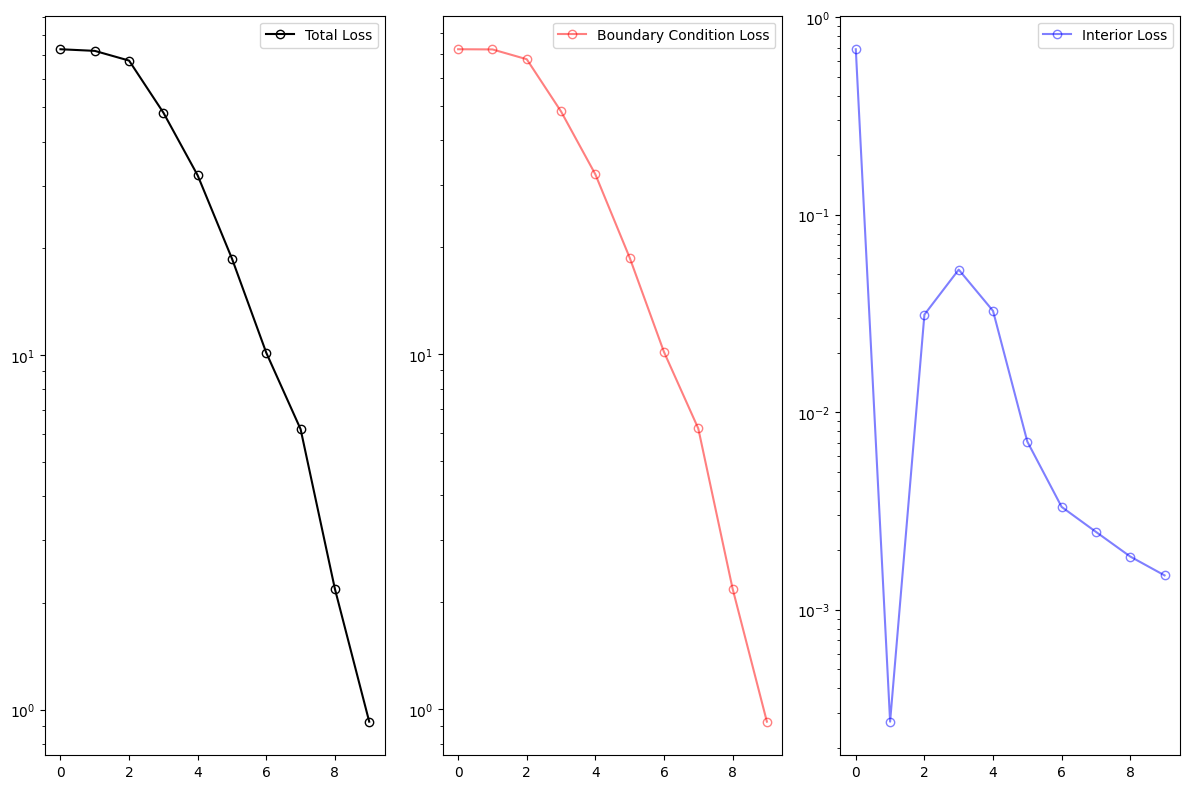

In [115]:
model.plot_losses()